In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [26]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [4]:
#Reading the data
df = pd.read_csv('Reviews.csv')
print(df.shape)
df = df.head(500)
print(df.shape)

(568454, 10)
(500, 10)


In [5]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Quick EDA

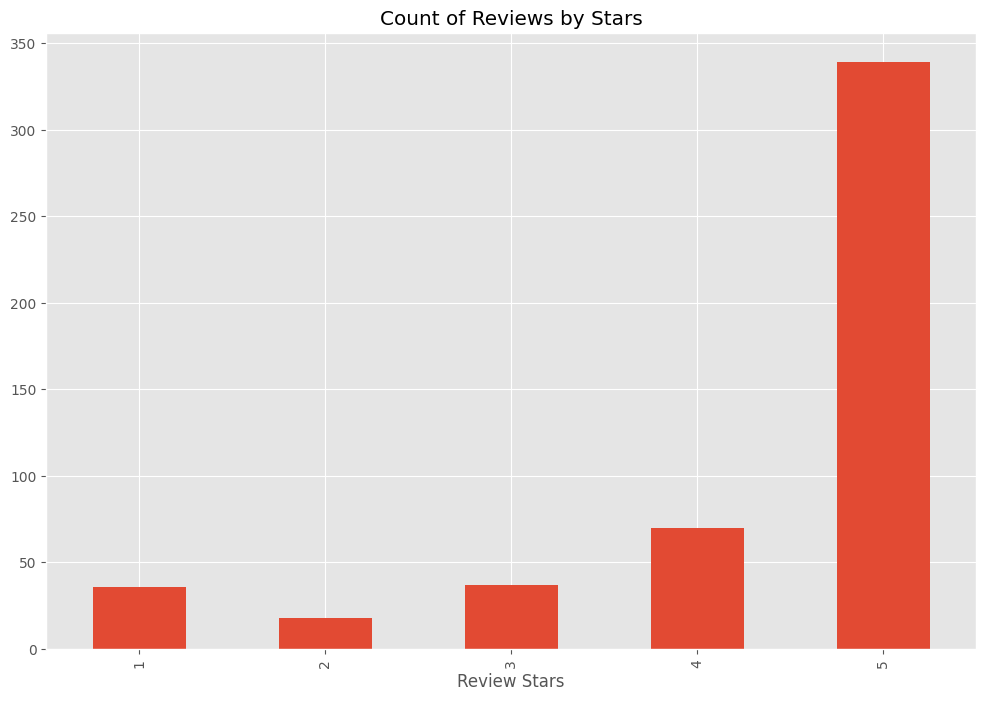

In [9]:
ax = df['Score'].value_counts().sort_index().plot(kind='bar',
                                           title='Count of Reviews by Stars',
                                           figsize=(12,8))
ax.set_xlabel('Review Stars')
plt.show()

Basic NLTK

In [11]:
sentence = df['Text'][100]
print(sentence)

The mouth says, "How do I love thee, let me count the ways..."<br />If you like apple products a must have item.  The only draw back, shipping cost.  These are very heavy.


In [15]:
tokenized = nltk.word_tokenize(sentence)
tokenized[:10]

['The', 'mouth', 'says', ',', '``', 'How', 'do', 'I', 'love', 'thee']

In [19]:
tag = nltk.pos_tag(tokenized)
tag[:10]

[('The', 'DT'),
 ('mouth', 'NN'),
 ('says', 'VBZ'),
 (',', ','),
 ('``', '``'),
 ('How', 'WRB'),
 ('do', 'VB'),
 ('I', 'PRP'),
 ('love', 'VB'),
 ('thee', 'NN')]

In [24]:
entity = nltk.chunk.ne_chunk(tag)
entity.pprint()

(S
  The/DT
  mouth/NN
  says/VBZ
  ,/,
  ``/``
  How/WRB
  do/VB
  I/PRP
  love/VB
  thee/NN
  ,/,
  let/VB
  me/PRP
  count/VB
  the/DT
  ways/NNS
  .../:
  ''/''
  </VBZ
  br/NN
  //NNP
  >/NNP
  If/IN
  you/PRP
  like/VBP
  apple/NN
  products/NNS
  a/DT
  must/MD
  have/VB
  item/NN
  ./.
  The/DT
  only/JJ
  draw/NN
  back/RB
  ,/,
  shipping/VBG
  cost/NN
  ./.
  These/DT
  are/VBP
  very/RB
  heavy/JJ
  ./.)


# Step 1. VADER Seniment Scoring

I'm using NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.

This uses a "bag of words" approach:
1. Stop words are removed
2. Each word is scored and combined to a total score



In [27]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
sao = SentimentIntensityAnalyzer()

In [30]:
sao.polarity_scores('I will conquer the world')

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [31]:
sao.polarity_scores(sentence)

{'neg': 0.0, 'neu': 0.807, 'pos': 0.193, 'compound': 0.7717}

In [34]:
#Running the polarity scores
resu = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    resu[myid] = sao.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [45]:
vader_results = pd.DataFrame(resu).T
vader_results = vader_results.reset_index().rename(columns={'index': 'Id'})
vader_results = vader_results.merge(df, how='left')
vader_results.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


from matplotlib import pyplot as plt
_df_11['Id'].plot(kind='hist', bins=20, title='Id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_12['neg'].plot(kind='hist', bins=20, title='neg')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_13['neu'].plot(kind='hist', bins=20, title='neu')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_14['pos'].plot(kind='hist', bins=20, title='pos')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_15.groupby('ProductId').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_16.groupby('UserId').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_17.groupby('ProfileName').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_18.groupby('Summary').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_19.plot(kind='scatter', x='Id', y='neg', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_20.plot(kind='scatter', x='neg', y='neu', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_21.plot(kind='scatter', x='neu', y='pos', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_22.plot(kind='scatter', x='pos', y='compound', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Id']
  ys = series['neg']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_23.sort_values('Id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('ProductId')):
  _plot_series(series, series_name, i)
  fig.legend(title='ProductId', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Id')
_ = plt.ylabel('neg')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Id']
  ys = series['neg']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_24.sort_values('Id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('UserId')):
  _plot_series(series, series_name, i)
  fig.legend(title='UserId', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Id')
_ = plt.ylabel('neg')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Id']
  ys = series['neg']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_25.sort_values('Id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('ProfileName')):
  _plot_series(series, series_name, i)
  fig.legend(title='ProfileName', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Id')
_ = plt.ylabel('neg')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Id']
  ys = series['neg']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_26.sort_values('Id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Summary')):
  _plot_series(series, series_name, i)
  fig.legend(title='Summary', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Id')
_ = plt.ylabel('neg')

from matplotlib import pyplot as plt
_df_27['Id'].plot(kind='line', figsize=(8, 4), title='Id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_28['neg'].plot(kind='line', figsize=(8, 4), title='neg')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_29['neu'].plot(kind='line', figsize=(8, 4), title='neu')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_30['pos'].plot(kind='line', figsize=(8, 4), title='pos')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['UserId'].value_counts()
    for x_label, grp in _df_31.groupby('ProductId')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('ProductId')
_ = plt.ylabel('UserId')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['ProfileName'].value_counts()
    for x_label, grp in _df_32.groupby('UserId')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('UserId')
_ = plt.ylabel('ProfileName')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Summary'].value_counts()
    for x_label, grp in _df_33.groupby('ProfileName')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('ProfileName')
_ = plt.ylabel('Summary')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Text'].value_counts()
    for x_label, grp in _df_34.groupby('Summary')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Summary')
_ = plt.ylabel('Text')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_35['ProductId'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_35, x='Id', y='ProductId', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_36['UserId'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_36, x='Id', y='UserId', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_37['ProfileName'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_37, x='Id', y='ProfileName', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_38['Summary'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_38, x='Id', y='Summary', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

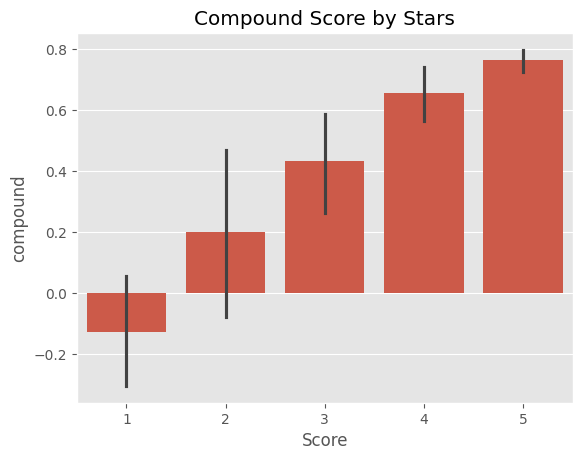

In [49]:
plottings = sns.barplot(data=vader_results, x='Score', y='compound')
plottings.set_title('Compound Score by Stars')
plt.show()

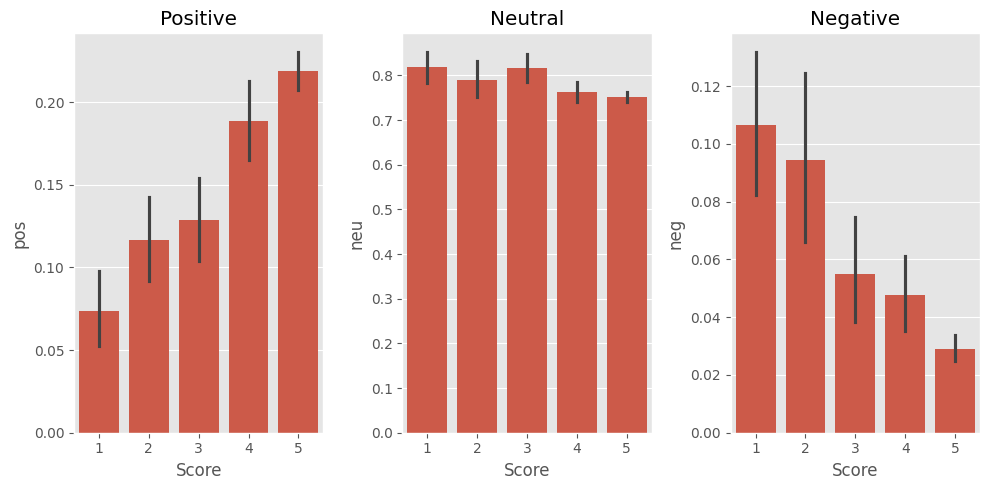

In [56]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
sns.barplot(data=vader_results, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vader_results, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vader_results, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Step 2. Roberta Pretrained Model

* Using a model that is already trained by a large corpus of data.
* Transformer model accounts for the words but also the context related to other words.


In [59]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [60]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [63]:
#Results of VADER on sentence
print(sentence)
sao.polarity_scores(sentence)

The mouth says, "How do I love thee, let me count the ways..."<br />If you like apple products a must have item.  The only draw back, shipping cost.  These are very heavy.


{'neg': 0.0, 'neu': 0.807, 'pos': 0.193, 'compound': 0.7717}

In [69]:
encoded_text = tokenizer(sentence, return_tensors='pt')
output = model(**encoded_text)
score = output[0][0].detach().numpy()
score = softmax(score)
score

array([0.30692118, 0.4565689 , 0.2365099 ], dtype=float32)

In [70]:
scores_dict = {
    'roberta_neg' : score[0],
    'roberta_neu' : score[1],
    'roberta_pos' : score[2]
}
print(scores_dict)

{'roberta_neg': 0.30692118, 'roberta_neu': 0.4565689, 'roberta_pos': 0.2365099}


In [71]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [77]:
resu = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
  try:
    text = row['Text']
    myid = row['Id']
    vader_result = sao.polarity_scores(text)
    vader_result_rename = {}
    for key, value in vader_result.items():
        vader_result_rename[f"vader_{key}"] = value
    roberta_result = polarity_scores_roberta(text)
    both_results = {**vader_result_rename, **roberta_result}
    resu[myid] = both_results
  except RuntimeError:
    print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [79]:
results_df = pd.DataFrame(resu).T
results_df = results_df.reset_index().rename(columns={'index': 'Id'})
results_df = results_df.merge(df, how='left')

In [80]:
results_df.columns

Index(['Id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ProductId', 'UserId',
       'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator',
       'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

##Comparing Scores between models

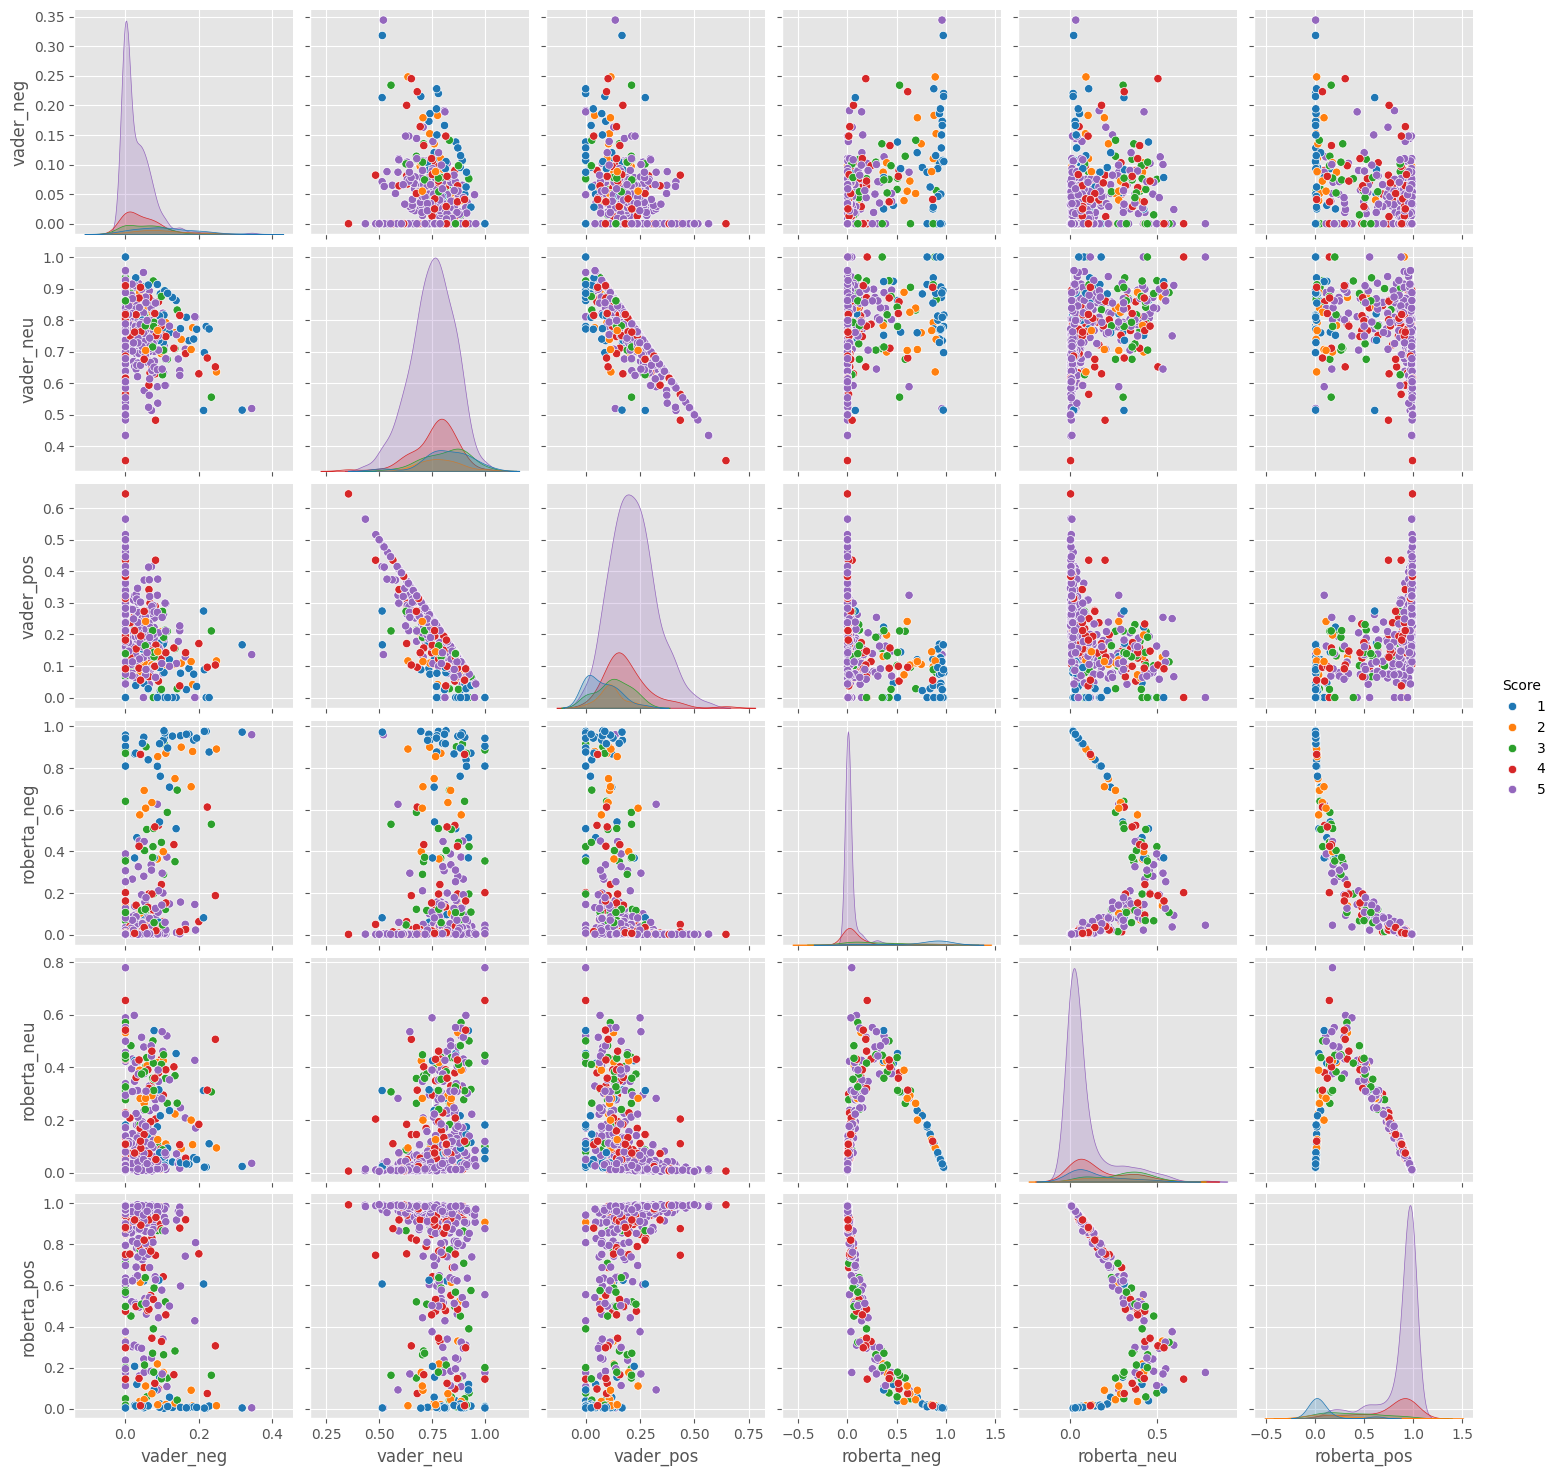

In [82]:
#Combine and Compare
sns.pairplot(data=results_df, vars=['vader_neg', 'vader_neu', 'vader_pos',
       'roberta_neg', 'roberta_neu', 'roberta_pos'],
             hue='Score',
             palette='tab10')
plt.show()

##Reviewing some examples:

In [84]:
results_df.query('Score == 1') \
    .sort_values('roberta_pos', ascending=False)['Text'].values[1]

"To me, these are nothing like the regular Altoids and are not breath mints. They are pleasant-tasting little candies in a cute convenient tin, and that's as far as it goes. The mintiness is just not strong, and the wintergreens are definitely weaker than the peppermint minis. I'm not a dragon-breath person, but still, one of these mints is too small to have any effect on my breath. Four or five will freshen my breath for a short while - maybe 15 minutes. At this point, I think the Icebreakers Frost mints are the best as sugar free breath mints."

In [88]:
results_df.query('Score == 1') \
    .sort_values('vader_pos', ascending=False)['Text'].values[1]

'Seriously this product was as tasteless as they come. There are much better tasting products out there but at 100 calories its better than a special k bar or cookie snack pack. You just have to season it or combine it with something else to share the flavor.'

In [89]:
#Negative 5-star review

In [95]:
results_df.query('Score == 5') \
    .sort_values('roberta_neg', ascending=False)['Text'].values[1]

'i know i cannot make tea this good.  granted, i am not from the south but i know i have never enjoyed tea that was this sweet without being too sweet.  it tastes crisp.'

In [96]:
results_df.query('Score == 5') \
    .sort_values('vader_neg', ascending=False)['Text'].values[1]

'What a deal this is the healthiest salt you can use.  This box should last our family the year no problem.  Iodized sea salt will not raise your blood pressure as regular salt will.'

##Transformers Pipelining


* A very quick and easy way to run sentiment predictions.
* Also easier and smarter for providing trustworthy results.



In [97]:
from transformers import pipeline
sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


In [98]:
sent_pipeline('I wanted the steak to be cooked medium rare but it was rare which ruined our whole dinner')

[{'label': 'NEGATIVE', 'score': 0.9997033476829529}]

In [99]:
sent_pipeline('The burger did not have any flavour whatsoever!! ugh!!')

[{'label': 'NEGATIVE', 'score': 0.999765932559967}]

In [100]:
sent_pipeline("The Shepherds pie was undoubtedly the best thing i've ever had")

[{'label': 'POSITIVE', 'score': 0.9996287822723389}]

In [101]:
sent_pipeline("I'm for sure coming to this place again!!!")

[{'label': 'POSITIVE', 'score': 0.9990405440330505}]